# Librerie

In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.8 MB/s eta 0:00:00


In [2]:
import os
from google.colab import drive

import numpy as np
import pandas as pd

import datasets
import evaluate
import seaborn as sns

# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Librerie per le metriche
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Caricamento dati

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_folder = "/content/drive/My Drive/profiling_input/journalism/profiling_input"
documents = os.listdir(data_folder)

train_data = []
test_data = []

# Creo una lista con le labels, per identificare quante sono e passare successivamente l'informazione direttamente al modello
labels = []

for document in documents:
  # Seleziono come label 'TOPIC'
  split = document.rstrip('.txt').split('#')[0]
  id = document.rstrip('.txt').split('#')[1]
  label = document.rstrip('.txt').split('#')[3]

  if not label in labels:
    labels.append(label)

  type_document = document.rstrip('.txt').split('#')[0]
  data = open('/content/drive/My Drive/profiling_input/journalism/profiling_input/' + document, 'r')
  text = data.read()

  input_instance = {}
  input_instance["id"] = id
  input_instance["sentence"] = text
  input_instance["label"] = label

  if type_document == "training":
    train_data.append(input_instance)
  else:
    test_data.append(input_instance)

# Creo un dizionario di mapping fra le labels come stringhe e le label numeriche
str_to_int = {label: num for num, label in enumerate(labels)}

In [5]:
# Conversione da lista di dizionari a dataset
train = datasets.Dataset.from_pandas(pd.DataFrame(data=train_data))
test = datasets.Dataset.from_pandas(pd.DataFrame(data=test_data))

# Splitting in train e dev del training set
train_dev = train.train_test_split(test_size=0.1)

train = train_dev["train"]
dev = train_dev["test"]

# Stampo 'train' per vedere come è formattato
print(train)
print()
print("Esempio di testo:", train['sentence'][2])
print()
print("Esempio di label:", train['label'][2])
print()

# Shape dei dati di train, dev e test
print("Dimensione dei training, development and test sets:")
print("Train:", train.shape)
print("Dev:", dev.shape)
print("Test:", test.shape)

Dataset({
    features: ['id', 'sentence', 'label'],
    num_rows: 180
})

Esempio di testo: Nidi privati, dal Comune più soldi e più posti
Convenzione per 500 bambini Sconti da 100 a 440 euro a famiglia in base al reddito
Rette massime che scendono da 900 a 700 euro con un contributo del Comune direttamente ai gestori. E ulteriori sconti per le famiglie che varieranno a seconda del reddito da 100 a 440 euro. Ė la nuova convenzione con i nidi privati approvata ieri in giunta che mette sul piatto del sistema integrato più risorse - si stima almeno il doppio - e più posti in convenzione, che passano da 380 dello scorso anno a 500.
« Rendiamo accessibili i nidi privati convenzionati, per chi lo vuole, anche alle famiglie meno abbienti con un sistema più equo, che impegna più risorse e aumenta i posti a disposizione alleggerendo in questo modo le liste d'attesa», commenta l'assessora alla scuola e vicesindaca Marilena Pillati.
Dopo la manovra per abbassare le rette negli asili comunali arr

In [6]:
# Creo una variabile 'model' dove specificherò il modello da utilizzare
model_name = 'dbmdz/bert-base-italian-cased'

# Carico il modello
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

# Carico il tokenizzatore
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

In [7]:
# Funzione che applica la tokenizzazione ai dati di training, dev e test
def tokenize(batch):
    tokens = tokenizer(batch['sentence'], padding=True, truncation=True, max_length=512)
    tokens['label'] = [str_to_int[label] for label in batch["label"]]

    return tokens

train = train.map(tokenize, batched=True)
dev = dev.map(tokenize, batched=True)
test = test.map(tokenize, batched=True)

train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
dev.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [8]:
# Trainer
import transformers
import accelerate

# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer



num_epochs = 5

training_args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
def compute_metrics(eval_pred):
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  return f1_metric.compute(predictions=predictions, references=labels, average="weighted")

In [10]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train,
    eval_dataset=dev,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("/content/drive/My Drive/FINETUNED_MODEL")

<ipython-input-10-f516442d2117>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1
1,0.700700,0.674581,0.496000
2,0.619500,0.632704,0.690909
3,0.498200,0.610722,0.746867
4,0.387200,0.593059,0.746867
5,0.312300,0.633647,0.690909


<ipython-input-11-bcdc75bb121a>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, log_df], ignore_index=True)


<Axes: xlabel='Epoch', ylabel='Loss'>

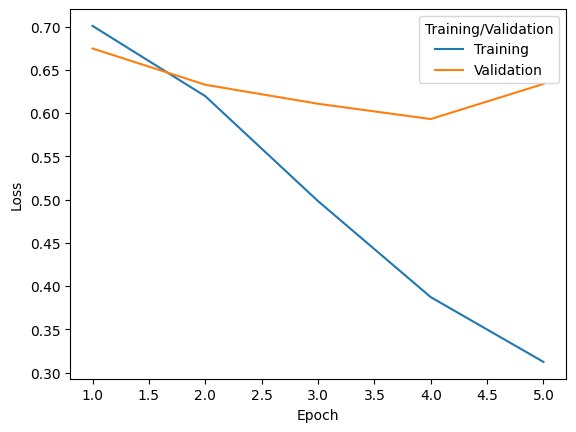

In [11]:
log_history = trainer.state.log_history

# Creo dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]

    log_df = pd.DataFrame({"Epoch": [epoch], "Loss": [loss], "Training/Validation": ["Training"]})
    df = pd.concat([df, log_df], ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    log_df = pd.DataFrame({"Epoch": [epoch], "Loss": [loss], "Training/Validation": ["Validation"]})
    df = pd.concat([df, log_df], ignore_index=True)

# Lineplot della loss
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Training/Validation")

In [12]:
output_predictions = trainer.predict(test)

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.70      0.61       100
           1       0.57      0.40      0.47       100

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.54       200
weighted avg       0.55      0.55      0.54       200


Confusion Matrix:


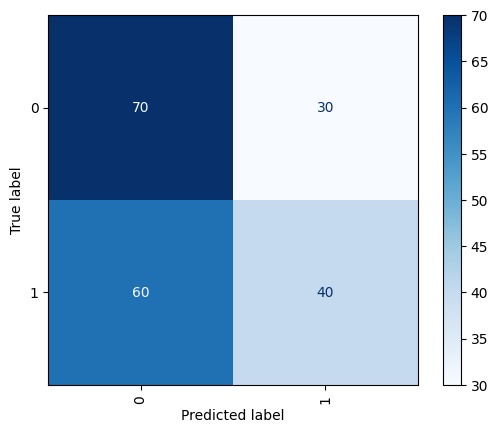

In [13]:
y_test = test["label"].tolist()
y_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_test, y_pred)
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues')

print("Classification Report:")
print(report)
print()

print("Confusion Matrix:")
print(cm)